# STYLE TRANSFER
### In this project we are going to be using Convolutional Neural Networks to implement Neural Style Transfer, a technique for creating a new image with the contenet of one input image and the style of another input. The idea behind style transfer is as follows: take three input images, one our style image, one our content image, and one output image which starts as random noise and we iteratively update it until it looks like the content of the content image in the style of the style image. To do this we run all three images through a pretrained VGG16 model trained to classify images. Then for a selected convolutional or pooling layer of the VGG16 model we compare the activations (values of the neurons) at that layer for the three different images. Specifically, we have what is called a feature reconstruction loss that compares the activations of the current output image and the content image, and what is called a style loss that compares the activations of the current output image and the desired style image. Then we use the gradient of these loss functions to update our current output image. Hopefully, that gives you an overview of what we will be doing, and you should gain a more in depth understanding as we go along.  

### The paper we will be implementing is found here: https://arxiv.org/pdf/1508.06576.pdf

# Part 1: Build Model and Define Losses

#### First we want to initialize a VGG16 model we can use for style transfer.  

In [1]:
from keras.applications import vgg16
from keras.layers import Input, Concatenate, concatenate
from keras.models import Model, Sequential
from keras import backend as K
import tensorflow as tf

Using TensorFlow backend.
/Users/sachin/anaconda/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
K.clear_session()
content_input = Input(batch_shape=(1, 224, 224, 3))
style_input = Input(batch_shape=(1, 224, 224, 3))
output_tensor = tf.get_variable("output_tensor", [1, 224, 224, 3])
output_input = Input(tensor=output_tensor)
## TODO: use a concatenate layer to concatenate the three inputs on the first axis.
#note: had to change Concatentate to concatentate because of some API requirement???
input_tensor = concatenate([content_input, style_input, output_input], axis= 1)

If you get an error for the cell below about SSL PROTOCOL VERSIONS or something similar you can try downloading this file
https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5
and putting it in the folder `~/.keras/models` on your computer. Then the cell below should work after that

In [3]:
# We now create a pretrained VGG 16 model, which is really easy to do in Keras
# include_top=False ensures we don't use the fully connected layers.
vgg_model = vgg16.VGG16(input_tensor=input_tensor, weights='imagenet', include_top=False)
# We can now look at the structure of this model
vgg_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (1, 224, 224, 3)     0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (1, 224, 224, 3)     0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (1, 224, 224, 3)     0                                            
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (1, 672, 224, 3)     0           input_1[0][0]                    
                                                                 input_2[0][0]                    
          

In [29]:
print([layer.name for layer in vgg_model.layers])

['input_1', 'input_2', 'input_3', 'concatenate_1', 'block1_conv1', 'block1_conv2', 'block1_pool', 'block2_conv1', 'block2_conv2', 'block2_pool', 'block3_conv1', 'block3_conv2', 'block3_conv3', 'block3_pool', 'block4_conv1', 'block4_conv2', 'block4_conv3', 'block4_pool', 'block5_conv1', 'block5_conv2', 'block5_conv3', 'block5_pool']


In [71]:
# now select one of the above listed layers to be the layer to use for content information
# and select some number of layers (maybe 2 or 3 layers) from the above layers to be the
# style information. If you choose layers closer to the input this will use 
# more simplistic features, and choosing layers closer to the end will use more complicated
# abstracted features.
content_layer = 'block2_conv1'
style_layers = [
    'block3_conv1',
    'block2_conv2'
]
# you can also play with the_content and style loss weights if you want to. this will effect 
# how stylized vs similar to the content image the output will look.
content_loss_weight = 5.0
style_loss_weight = 500.0

In [72]:
layers_dict = dict([(layer.name, layer.output) for layer in vgg_model.layers])

### Loss Functions
We want to define our style transfer losses now. First, we are going to define a feature reconstruction loss based on our content features and our output features. Using tensorflow functions implement the following loss function: $$\frac{1}{2} \sum_{i,j, k} (F_{ijk} - P_{ijk})^2$$ where $F$ is the 3D tensor of content features and $P$ is the 3D tensor of our output image features. HINT: tf.reduce_sum and tf.square will be helpful here.

In [73]:
def feature_reconstruction_loss(content_img_features, output_img_features):
    """Takes a tensor representing a layer of VGG features from the content image
    and a tensor representing a layer of VGG features from the current output image and returns a loss value.
    """
    #double check this, kinda sus
    return tf.reduce_sum(tf.square(content_img_features - output_img_features))

Now we wish to define our style loss function. First, we have to take our features and represent them as a Gram Matrix, for more information on Gram Matrices and this loss function you can read the paper if you like. Then we wish to implement the loss function:
$$ \frac{1}{4H^2W^2C^2} \sum_{ij} (G_{ij} - A_{ij})^2 $$ where $G$ is the Gram matrix of the output image features and $A$ is the Gram Matrix of the style image features. Note that we have written a Gram matrix function for you so you only need to call it.

In [74]:
def gram_matrix(x):
    # make channels first dimension
    x = tf.transpose(x, (2, 0, 1))
    # flatten everything but channels so x is now (C, H*W)
    x = tf.reshape(x, tf.stack([-1, tf.reduce_prod(tf.shape(x)[1:])]))
    return tf.matmul(x, tf.transpose(x))

In [75]:
def style_loss(style_img_features, output_img_features, img_shape):
    """Takes a tensor representing a layer of VGG features from the style image and a tensor
    representing a layer of VGG features from the current output image and returns 
    the style loss for these features.
    """
    LOSS = tf.reduce_sum(tf.square(style_img_features - output_img_features))
    return 1/ (4 * img_shape[0]**2 * img_shape[1]**2 * img_shape[2]**2) * LOSS

In [76]:
content_features = layers_dict[content_layer]
#note had to change the feature variables to tf.transpose(variable)[index] instead of variable[index]
content_img_features = tf.transpose(content_features)[0, :, :, :]
output_content_features = tf.transpose(content_features)[2, :, :, :]
content_loss = feature_reconstruction_loss(content_img_features, output_content_features)

In [77]:
total_style_loss = tf.zeros(1)
weight = 1.0 / len(style_layers)
for style_layer in style_layers:
    style_features = layers_dict[style_layer]
    style_img_features = tf.transpose(style_features)[1, :, :, :]
    output_img_features = tf.transpose(style_features)[2, :, :, :]
    total_style_loss += weight * style_loss(style_img_features, output_img_features, (224, 224, 3))

Now we need to combine our two loss functions using the weightings we defined earlier. HINT: don't overthink this it should be a very simple operation.

In [78]:
###TODO: PLEASE DOUBLE CHECK THIS
loss_1 = content_loss_weight * content_loss
loss_2 = style_loss_weight * total_style_loss 
total_loss = loss_1 + loss_2
print(total_loss)

Tensor("add_8:0", shape=(1,), dtype=float32)


In [79]:
optimize = tf.train.AdamOptimizer(learning_rate=10).minimize(total_loss, var_list=[output_tensor])

# Part 2: Feeding in Images

We now want to load and preprocess our images. keras provides a `load_img` function that conviently loads our image and then cuts it down to our target size. Keras also provides a `vgg16.preprocess_input` that preprocesses images to be in the format vgg16 expects. Use these two functions to write the load_image function below.

In [80]:
from keras.preprocessing.image import load_img, img_to_array
import numpy as np
def load_image(img_path):
     #YOUR CODE HERE call load img and set the target size to be (224,224,3)
    img = load_img(img_path, target_size = (224,224,3))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg16.preprocess_input(img)
    return img

def deprocess_image(x):
    x = x.reshape((224, 224, 3))
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [81]:
content_img_path = 'images/KobeContent2.jpg'
style_img_path = 'images/pt2.jpg'

In [82]:
content_img = load_image(content_img_path)
style_img = load_image(style_img_path)

In [83]:
import matplotlib.pyplot as plt
%matplotlib inline

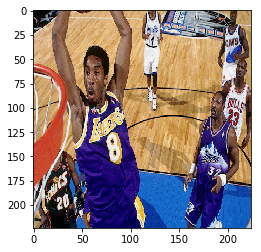

In [84]:
plt.imshow(deprocess_image(content_img))

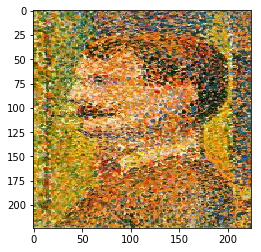

In [85]:
plt.imshow(deprocess_image(style_img))

# Part 3: Stylize Images

In [86]:
assign_var = tf.assign(output_tensor, content_img)
sess = K.get_session()
var = sess.run(assign_var)

Running the cell below will update the image 10 times. Since the initialization code is in the cell above, if you run the cell below and you're output isn't great you can run for another 10 iterations simply by rerunning the cell below.

In [87]:
n_iterations = 10
for i in range(n_iterations):
    print("Running iteration: {}".format(i))
    _, output_val, loss = sess.run([optimize, output_tensor, total_loss], feed_dict={content_input: content_img, style_input: style_img})

Running iteration: 0
Running iteration: 1
Running iteration: 2
Running iteration: 3
Running iteration: 4
Running iteration: 5
Running iteration: 6
Running iteration: 7
Running iteration: 8
Running iteration: 9


In [88]:
output_img = deprocess_image(output_val)

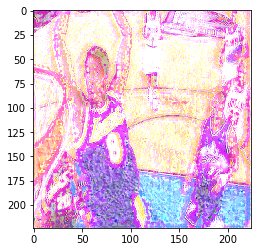

In [89]:
plt.imshow(output_img)

# Part 4: Style Transfer Writeup

Now you need to writeup your project. First, write a short paragraph about your understanding of how style transfer works. Feel free to refer to the paper if it helps but your paragraph needs to be in your own words. 

Then attach 3 sets of images to your writeup. For each set show the original content image, the original style image, and the style transfer result. One set should be the images we provided here, include the content and style layers you used as well as the content and style weights you used. Another set should be the images we provided here but with different content layers, style layers and different content and style weights, include your choices for the layers and weights in your writeup. Finally, include a set of images that is based on a new content image and a new style image that you choose yourself. There will be an award for the group with the coolest style transfer result. 